In [2]:
%matplotlib inline
import numpy as np
import random
from __future__ import division
import wave, struct, numpy as np, matplotlib.mlab as mlab, pylab as pl
import matplotlib.pyplot as plt

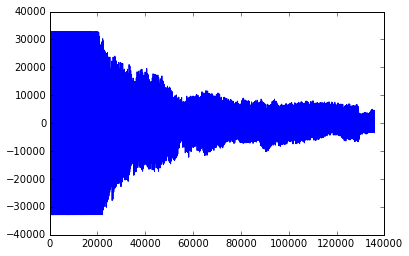

In [8]:
filename = "CG.wav"
w = wave.open(filename,"rb")

#returns a named tuple (nchannels, sampwidth, framerate, 
# nframes, comptype, compname)
waveParams = w.getparams()

s = w.readframes(waveParams[3])
w.close()
waveArray = np.fromstring(s, np.int16)

pl.figure()
pl.plot(waveArray)

spectrum, freq, bins = mlab.specgram(waveArray, NFFT=256,Fs=waveParams[2],sides='onesided')


In [ ]:
# calculates and returns spectrogram of 
def get_wav(filename)
    filename = "CML_Recording_Both.wav"
    w = wave.open(filename,"rb")
    return w

# spectrogram is the absolute value of the stft
def get_sepctrogram(stft):
    return abs(stft)

# takes in wave file as input
# win_size is the length of the window in samples
# overlap is the amount of overlap between windows in samples
def my_stft(w, win_size, overlap):
    # number of samples in the wave file
    n = len(w)
    win_count= 0
    

def my_istft(stft):
    

In [3]:
# epsilon divergence
def compute_obj(v,W,h,eps):
    whv = (np.dot(W,h) + eps)/(v + eps)
    div = whv - np.log(whv) - 1 
    return np.sum( div )

# epsilon divergence gradient
def compute_grad(v,W,h,eps):
    grad = np.dot(W.T, (1/(v + eps) - 1/(np.dot(W,h) + eps)))
    return grad

# important! input here has to be the matrix H, not the vector h_t
# this is because we need h_t but also h_(t-1) and h_(t+1)
# ind_t is the index of h_t in H
# lambda is the smoothness constant
def compute_smooth_obj(v,W,H,ind_t,lamb,eps):
    
    # get the column h_t
    h = H[:,ind_t]
    h = h.reshape(h.shape[0],1)
    
    # compute regular objective
    # maybe doing this direct instead of the function call is faster:
    # whv = (np.dot(W,h) + eps)/(v + eps)
    # div = whv - np.log(whv) - 1 
    div = compute_obj(v,W,h,eps)
    
    # compute smoothness terms
    s1 = H[:,ind_t]/H[:,ind_t-1]
    s2 = H[:,ind_t]/H[:,ind_t+1]
    sm = s1 - np.log(s1) - 1
    sm += s2 - np.log(s2) - 1
    # returning properly scaled smooth objective
    return div + lamb * np.sum( sm )
    
# input parameters as above
def compute_smooth_grad(v,W,H,ind_t,lamb,eps):
    
    # get the column h_t
    h = H[:,ind_t]
    h = h.reshape(h.shape[0],1)
    
    # calculates gradient of regular divergence
    div_grad = compute_grad(v,W,h,eps)

    # calculating gradient of smoothness term
    sm_grad = 1/H[:,ind_t-1] + 1/H[:,ind_t+1] - 2/H[:,ind_t]
    sm_grad = sm_grad.reshape(sm_grad.shape[0],1)
    
    # returning properly scaled gradient of smooth objective 
    return div_grad + lamb * sm_grad
    

In [4]:
def grad_checker(v, W, h):
    eps = 1e-3
    (f,k) = W.shape
    t_grad = np.zeros(h.shape)
    for i in range(k):
        ei = np.zeros(h.shape)
        ei[i] = eps
        t_grad[i] = (compute_obj(v,W,h+ei, 1e-12) - compute_obj(v,W,h-ei,1e-12)) / (2*eps)
    print(t_grad)
    print(compute_grad(v,W,h,1e-12))
    
grad_checker(np.random.rand(2,1), np.random.rand(2,2),np.random.rand(2, 1))

[[ 0.05074009]
 [-0.18438291]]
[[ 0.05074023]
 [-0.18438248]]


In [5]:
# second grad checker for smooth objective functions: Works!
def grad_checker(v,W,H,ind_t,lamb,eps):
    eps_dif = 1e-3
    (f,k) = W.shape
    t_grad = np.zeros(H[:,ind_t].shape)
    for i in range(k):
        ei = np.zeros(H.shape)
        ei[i,ind_t] = eps_dif
        t_grad[i] = (compute_smooth_obj(v,W,H+ei,ind_t,lamb,eps) - compute_smooth_obj(v,W,H-ei,ind_t,lamb,eps)) / (2*eps_dif)
    print(t_grad)
    print(compute_smooth_grad(v,W,H,ind_t,lamb,eps))
grad_checker(np.random.rand(2,1), np.random.rand(2,2),np.random.rand(2, 3),1,1,1e-12)

[ 1.39646765  7.45627802]
[[ 1.3964726 ]
 [ 7.45628738]]


In [34]:
def gradient_backtracking(v, W, h, max_iter, compute_grad, compute_obj, eps):
    
    v = v.reshape(v.shape[0],1)
  
    beta = 0.5 #backstep factor between 0.1 and 0.8
    opt_prec = 1-1e-4 # optimization precision
    n = 1e-1 #initial step size
    
    h = np.random.rand(2, 1)
    
    obj = [None]*max_iter
    
    max_backstep = 100 # maximum number of backsteps
    t = 0 # backstepping counter
    k = 0 # gradient step counter 
    
    while( k < max_iter and t != max_backstep ):
        
        grad = compute_grad(v,W,h,eps)
        obj[k] = compute_obj(v,W,h,eps)
        
        t = 0 # reset backstepping counter
        n = 1/beta*n # try to increase stepsize slightly again
        
        # make sure h-n*grad is positive
        while(any(h - n * grad < 0)  and t < max_backstep ):
            t += 1
            n = beta * n
    
        new_obj = compute_obj(v,W,(h - n*grad),eps)
        while( new_obj > opt_prec * compute_obj(v,W,h,eps) and t < max_backstep):
            t += 1
            n = beta * n
            new_obj = abs(compute_obj(v,W,(h - n*grad),eps))
                      
        h = h - n * grad # update h according to gradient step
        k += 1 # update gradient step counter
       
    h = h.reshape(h.shape[0],)
    return h, obj[0:k]

h, obj = gradient_backtracking(np.random.rand(10,1), np.random.rand(10,2),  np.random.rand(2, 1), 100, compute_grad, compute_obj, 1e-12)


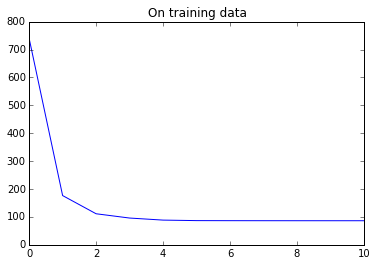

In [35]:
index = [i for i in range(10)]
plt.title("On training data")
plt.plot([i for i in range(len(obj))], obj)


In [79]:
def online_nmf(spectrum, W, H,A, B, rho, beta, n, eps):
   
    H = H.T
    a = np.zeros(W.shape)
    b = np.zeros(W.shape)
    
    t = 1
    W_old = W
    k = W.shape[1]
    h = np.random.rand(W.shape[1],)
    h_old = h
    
    
    while np.linalg.norm(W - W_old, ord = "fro") < n:
        
        t = t+1 
        
        ind = random.randint(0, len(spectrum.T)-1)
        v = spectrum.T[ind]
        h_old = h
        h, obj = gradient_backtracking(v, W, h_old, 100, compute_grad, compute_obj, 1e-12)
       
        
        H[ind] = h
       
        h = h.reshape(h.shape[0],1)
        v = v.reshape(v.shape[0],1)
        den = eps + np.dot(W, h)
        
        a += np.dot(np.dot(((eps+v)/(den**2)), h.T), np.dot(W.T,W))
        b += np.dot(1/den, h.T)
        
        if t % beta == 0:
            A = A + rho*a
            a = 0
            B = B + rho*b
            b = 0
            W_old = W
            W = np.sqrt(A/B)
            
            W = np.array([x/sum(x) for x in zip(*W)]).T
            A = np.array([x/sum(x) for x in zip(*A)]).T
            B = np.array([x*sum(x) for x in zip(*B)]).T
            
        if t > 500:
            print(W.shape)
            break

    print(t)
    return W, H.T


In [80]:
eps = 1e-12
v = spectrum.T[0]
K = 2
W = np.random.rand(spectrum.shape[0],K)
H = np.zeros((K, spectrum.shape[1]))

A = np.zeros(W.shape)
B = np.zeros(W.shape)


W, H = online_nmf(spectrum, W, H, A, B, 0.5, 100, 1e-12, eps)

100


/Users/aarti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [81]:
W.shape

(129, 2)

In [82]:
H.shape

(2, 1060)

In [83]:
spectrum.shape

(129, 1060)

In [94]:
l_win = 256
overlap = lwin/2
N = spectrum.shape[1]
Tpad = int(l_win + (N-1)*(l_win-overlap))

c = np.zeros((K,Tpad))
V = np.dot(W, H)

In [98]:
def istft(stft, window, overlap):
    W = len(window)
    
    if W % 2 == 0:
        stft = [stft, stft[W/2:-1:2,:].conj()]
    else:
        stft = [stft, stft[(W+1)/2:-1:2].conj()]
        
    istft = np.fft.ifftn(stft)
    
    xpad = cf_overlap_add(ISTFT,SY_WINDOW,OVERLAP)